In [2]:
import numpy as np
!pip install tensorflow
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import to_categorical
from PIL import Image

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# Define constants
BATCH_SIZE = 64
TRAIN_DIR = 'C:/Users/dilee/Downloads/asl_alphabet_train/asl_alphabet_train'
TEST_DIR = 'C:/Users/dilee/Downloads/asl_alphabet_test/asl_alphabet_test'

In [6]:
# Load train data
train_ds = image_dataset_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    shuffle=True,
    subset="training",
    validation_split=0.2,
    seed=33
)

# Creating a validation data
val_ds = image_dataset_from_directory(
    TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=(128, 128),
    subset="validation",
    validation_split=0.2,
    seed=33
)

# Load test data
img_size = (128, 128)
test_images = []
test_labels = []

for filename in os.listdir(TEST_DIR):
    if filename.endswith('.jpg'):
        img_path = os.path.join(TEST_DIR, filename)
        label = filename.split('_')[0]  # A_test.jpg -> A

        # Görüntüyü oku ve resize et
        img = Image.open(img_path).convert('RGB')
        img = img.resize(img_size)
        img_array = np.array(img) / 255.0  # Normalizasyon
        test_images.append(img_array)
        test_labels.append(label)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.


In [7]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    tf.keras.layers.Rescaling(scale=1./255),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(29, activation='softmax')
])

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Summarize the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 413,853 (1.58 MB)

 Trainable params: 413,853 (1.58 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(patience=3, mobitor='val_loss', verbose=1)
]

In [11]:
# Label encode
label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)

In [12]:
# One-hot encode
test_labels_onehot = to_categorical(test_labels_encoded, num_classes=29)

In [13]:
import numpy as np
print(np.array(test_labels).shape)
print(np.array(test_labels_encoded).shape)
print(np.array(test_labels_onehot).shape)


(28,)
(28,)
(28, 29)


In [14]:
print(os.listdir(TEST_DIR))

['A_test.jpg', 'B_test.jpg', 'C_test.jpg', 'D_test.jpg', 'E_test.jpg', 'F_test.jpg', 'G_test.jpg', 'H_test.jpg', 'I_test.jpg', 'J_test.jpg', 'K_test.jpg', 'L_test.jpg', 'M_test.jpg', 'nothing_test.jpg', 'N_test.jpg', 'O_test.jpg', 'P_test.jpg', 'Q_test.jpg', 'R_test.jpg', 'space_test.jpg', 'S_test.jpg', 'T_test.jpg', 'U_test.jpg', 'V_test.jpg', 'W_test.jpg', 'X_test.jpg', 'Y_test.jpg', 'Z_test.jpg']


In [15]:
print(f"Toplam test görüntüsü: {len(test_images)}")
print(f"Toplam test label: {len(test_labels)}")

Toplam test görüntüsü: 28
Toplam test label: 28


In [16]:
# Fit the model
history = model.fit(
    train_ds,
    epochs=6,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/6
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1204 - loss: 2.9787
Epoch 1: val_loss improved from None to 1.30964, saving model to best_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 3630s 3s/step - accuracy: 0.2480 - loss: 2.4223 - val_accuracy: 0.5719 - val_loss: 1.3096 - learning_rate: 0.0010
Epoch 2/6
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5518 - loss: 1.2909
Epoch 2: val_loss improved from 1.30964 to 0.60053, saving model to best_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2865s 3s/step - accuracy: 0.6174 - loss: 1.0993 - val_accuracy: 0.8116 - val_loss: 0.6005 - learning_rate: 0.0010
Epoch 3/6
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7498 - loss: 0.7110
Epoch 3: val_loss improved from 0.60053 to 0.37384, saving model to best_model.keras
1088/1088 ━━━━━━━━━━━━━━━━━━━━ 2864s 3s/step - accuracy: 0.7744 - loss: 0.6372 - val_accuracy: 0.8654 - val_loss: 0.3738 - learning_rate: 0.0010
Epoch 4/6
 893/1088 ━━━━━━━━━━━━━━━━━━━━ 8:09 3s/step -

In [17]:
# Taking batches and sampling
all_images = []
all_labels = []

for images, labels in train_ds.take(16):  # 16 batch x 64 batch_size = 1024 sample
    all_images.append(images)
    all_labels.append(labels)

x_sample = tf.concat(all_images, axis=0)
y_sample = tf.concat(all_labels, axis=0)

In [18]:
# Predict
pred_probs = model.predict(x_sample)
y_pred = np.argmax(pred_probs, axis=1)
y_true = y_sample.numpy()

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step


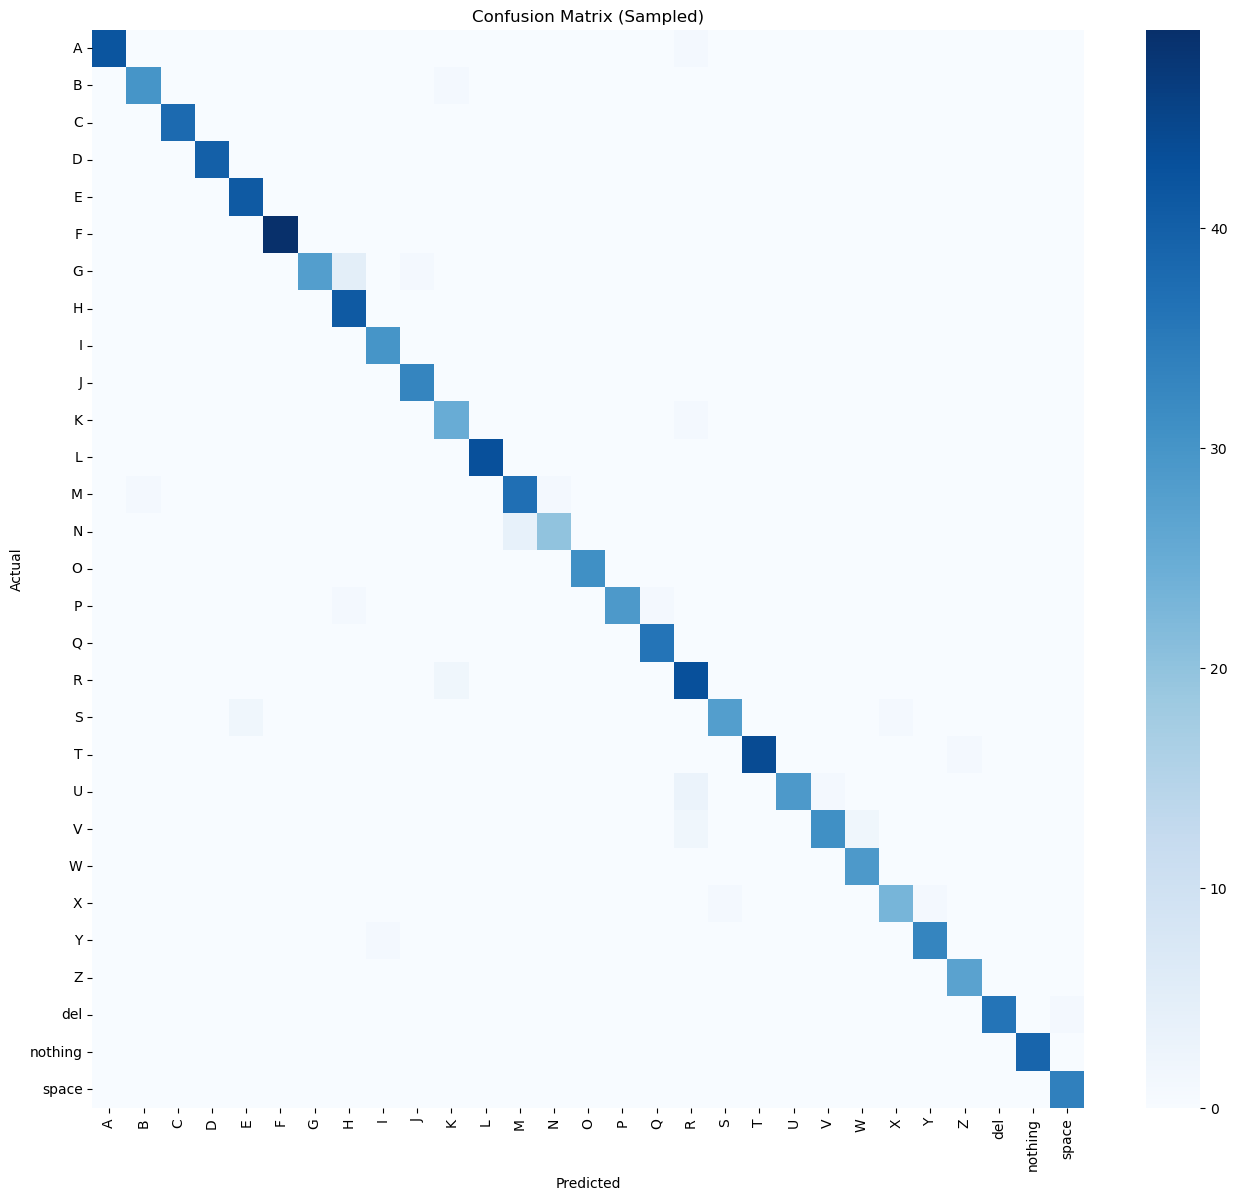

In [19]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d',
            xticklabels=train_ds.class_names,
            yticklabels=train_ds.class_names,
            cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Sampled)')
plt.show()

In [20]:
# Classification report
print(classification_report(y_true, y_pred, target_names=train_ds.class_names))

              precision    recall  f1-score   support

           A       1.00      0.98      0.99        43
           B       0.97      0.97      0.97        31
           C       1.00      1.00      1.00        38
           D       1.00      1.00      1.00        40
           E       0.95      1.00      0.98        41
           F       1.00      1.00      1.00        49
           G       1.00      0.82      0.90        34
           H       0.87      1.00      0.93        41
           I       0.97      1.00      0.98        30
           J       0.97      1.00      0.99        33
           K       0.89      0.96      0.93        26
           L       1.00      1.00      1.00        43
           M       0.90      0.95      0.93        39
           N       0.95      0.83      0.89        24
           O       1.00      1.00      1.00        31
           P       1.00      0.94      0.97        31
           Q       0.97      1.00      0.99        36
           R       0.86    

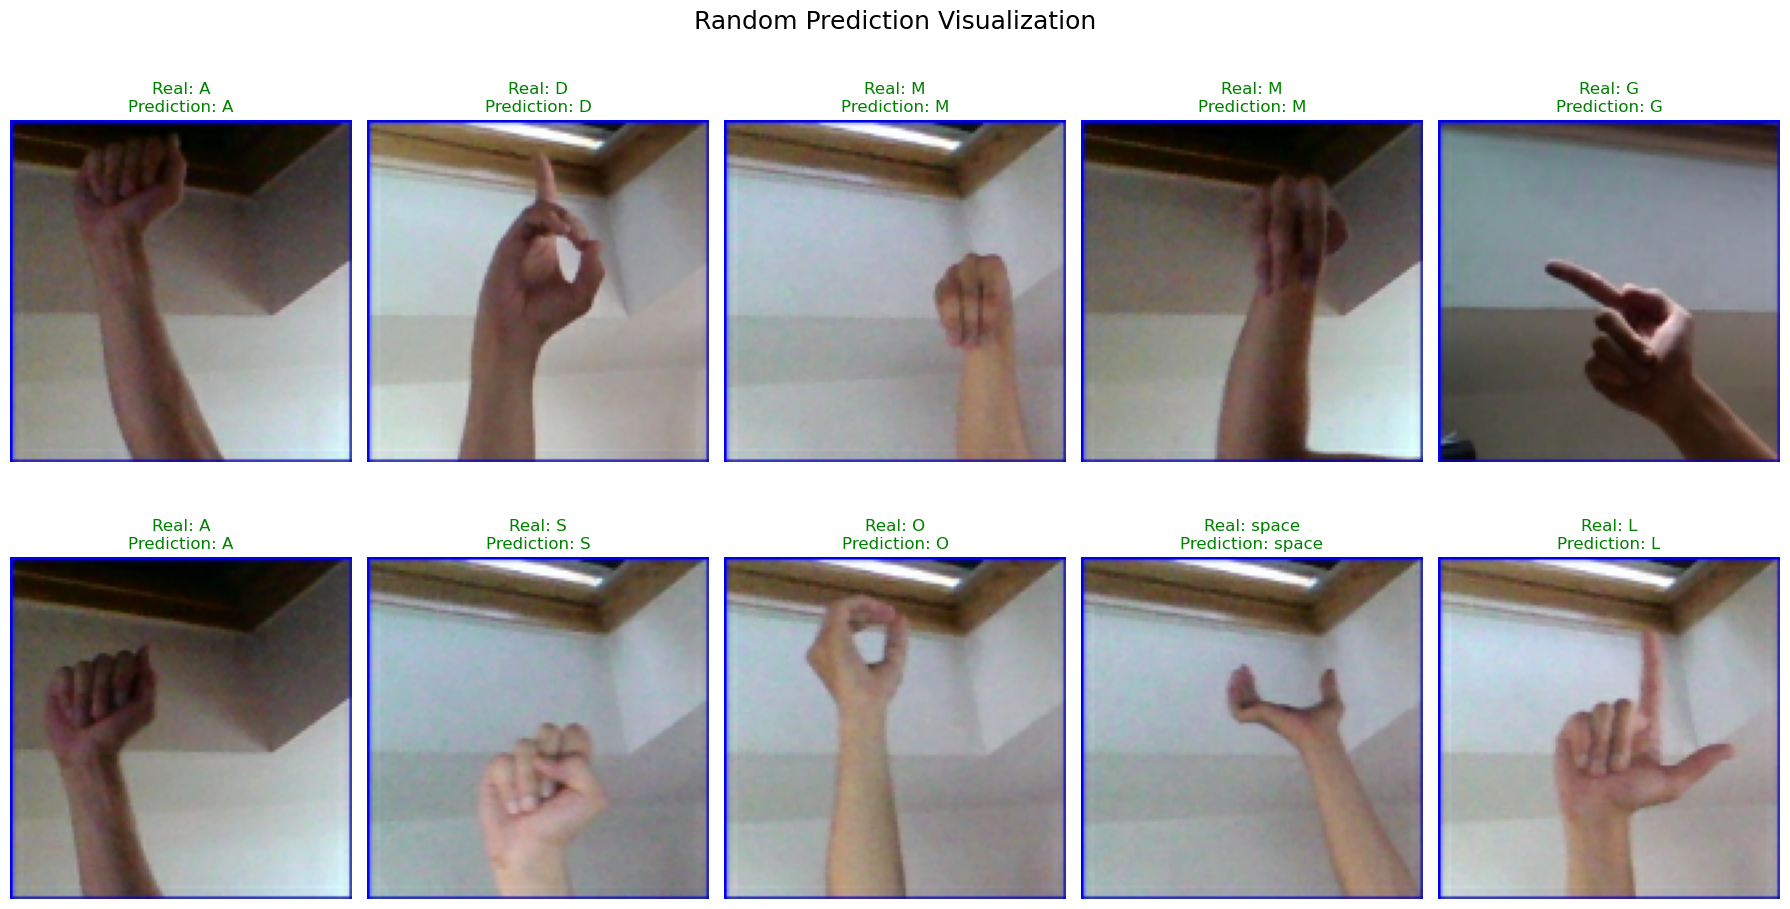

In [21]:
# Visualize random 10 instances
plt.figure(figsize=(18, 10))
for i in range(10):
    idx = np.random.randint(0, len(x_sample))
    img = x_sample[idx].numpy()
    true_label = train_ds.class_names[y_true[idx]]
    pred_label = train_ds.class_names[y_pred[idx]]
    
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.astype("uint8"))
    plt.title(f"Real: {true_label}\nPrediction: {pred_label}", color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.suptitle("Random Prediction Visualization", fontsize=18)
plt.tight_layout()
plt.show()